In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [25]:
import scanorama

C:\Users\Lau Lab\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#human data cross test
train = sc.read_h5ad('../data/colon_10x.h5ad')
test2 = sc.read_h5ad('../data/4058_AS1.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
positive2 = sc.read_h5ad('../data/4058_AS1_MitoFilter.h5ad')

In [4]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(train)
reorder_adata(test2)
# create new "observations" as percent and mean mito genes
test2.var['mito'] = test2.var_names.str.contains('mt-') # identify mitochondrial genes
test2.obs['mean_mito'] = np.mean(test2[:,test2.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test2, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# create new "observations" as percent and mean mito genes
train.var['mito'] = train.var_names.str.contains('mt-') # identify mitochondrial genes
train.obs['mean_mito'] = np.mean(train[:,train.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(train, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# rank cells by total counts and save as .obs
test2.obs['ranked_total_counts'] = np.argsort(test2.obs['total_counts'])
train.obs['ranked_total_counts'] = np.argsort(train.obs['total_counts'])

Wall time: 22.7 s


In [5]:
#For Bob's Filter    
f2 = np.isin(test2.obs.index, positive2.obs.index)
test2.obs['ken_filter']=0
test2.obs.loc[f2, 'ken_filter'] = 1

In [7]:
len(test2.var)

21611

In [6]:
#Common gene index search
common = np.isin(train.var.index, test2.var.index)
#Common gene list + new anndata
common_gene= []
for i in range(0,len(common)):
    if common[i]:
        common_gene.append(train.var.index[i])

In [7]:
len(common_gene)

20709

In [8]:
#new anndata
train_common_genes = train[:, common_gene]
test2_common_genes = test2[:, common_gene]

In [9]:
train_common_genes.obs['set'] = 'train'
test2_common_genes.obs['set'] = 'test'

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [10]:
merge_data = train_common_genes.concatenate(test2_common_genes)

In [11]:
%%time
sc.pp.normalize_total(merge_data, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(merge_data) # log1p transformation
sc.pp.scale(merge_data, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 49.3 s


In [12]:
%%time
sc.pp.normalize_total(test2_common_genes, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(test2_common_genes) # log1p transformation
sc.pp.scale(test2_common_genes, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 39.4 s


... storing 'set' as categorical


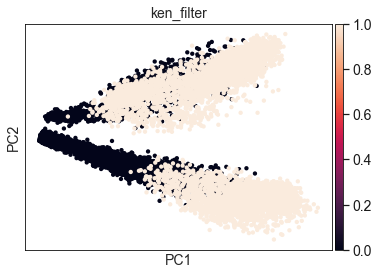

... storing 'set' as categorical


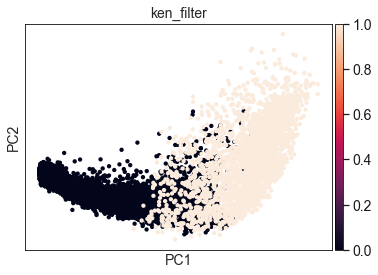

In [13]:
sc.tl.pca(merge_data, n_comps=100) # perform PCA and plot results
sc.pl.pca(merge_data, color=['ken_filter'], ncols=4, size=75)
sc.tl.pca(test2_common_genes, n_comps=10) # perform PCA and plot results
sc.pl.pca(test2_common_genes, color=['ken_filter'], ncols=4, size=75)

In [17]:
array1 = np.where(merge_data.obs['set']== 'train')
array2 = np.where(merge_data.obs['set']== 'test')
X=merge_data.obsm['X_pca'] 
y=merge_data.obs['ken_filter']

rf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=2)
lr = LogisticRegressionCV(cv=5, random_state=2, multi_class='multinomial', max_iter=1000)

rf.fit(X[array2[0]], y[array2[0]])
prediction = rf.predict(X[array1[0]])
train.obs['binary']=prediction


In [18]:
f_positive = 0
f_negative = 0
for i in range(0,len(train)):
    if train.obs['binary'][i]-train.obs['ken_filter'][i]>0:
        f_positive +=1
    if train.obs['binary'][i]-train.obs['ken_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_negative)/sum(train.obs['ken_filter']))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; correct N-label percent is %0.2f)' % total_acc)

miss-labeled as cell: 134 ; mislabeled as empty: 893 ; correct N-label percent is 0.77)


In [16]:
test2.obs['ken_filter'].value_counts()

0    26449
1     2685
Name: ken_filter, dtype: int64

In [30]:
f_positive = 0
f_negative = 0
for i in range(0,len(test2)):
    if test2_common_genes.obs['binary'][i]-test2_common_genes.obs['ken_filter'][i]>0:
        f_positive +=1
    if test2_common_genes.obs['binary'][i]-test2_common_genes.obs['ken_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_negative)/sum(test2.obs['ken_filter']))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; correct N-label percent is %0.2f)' % total_acc)

miss-labeled as cell: 17614 ; mislabeled as empty: 282 ; correct N-label percent is 0.89)


C:\Users\Lau Lab\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


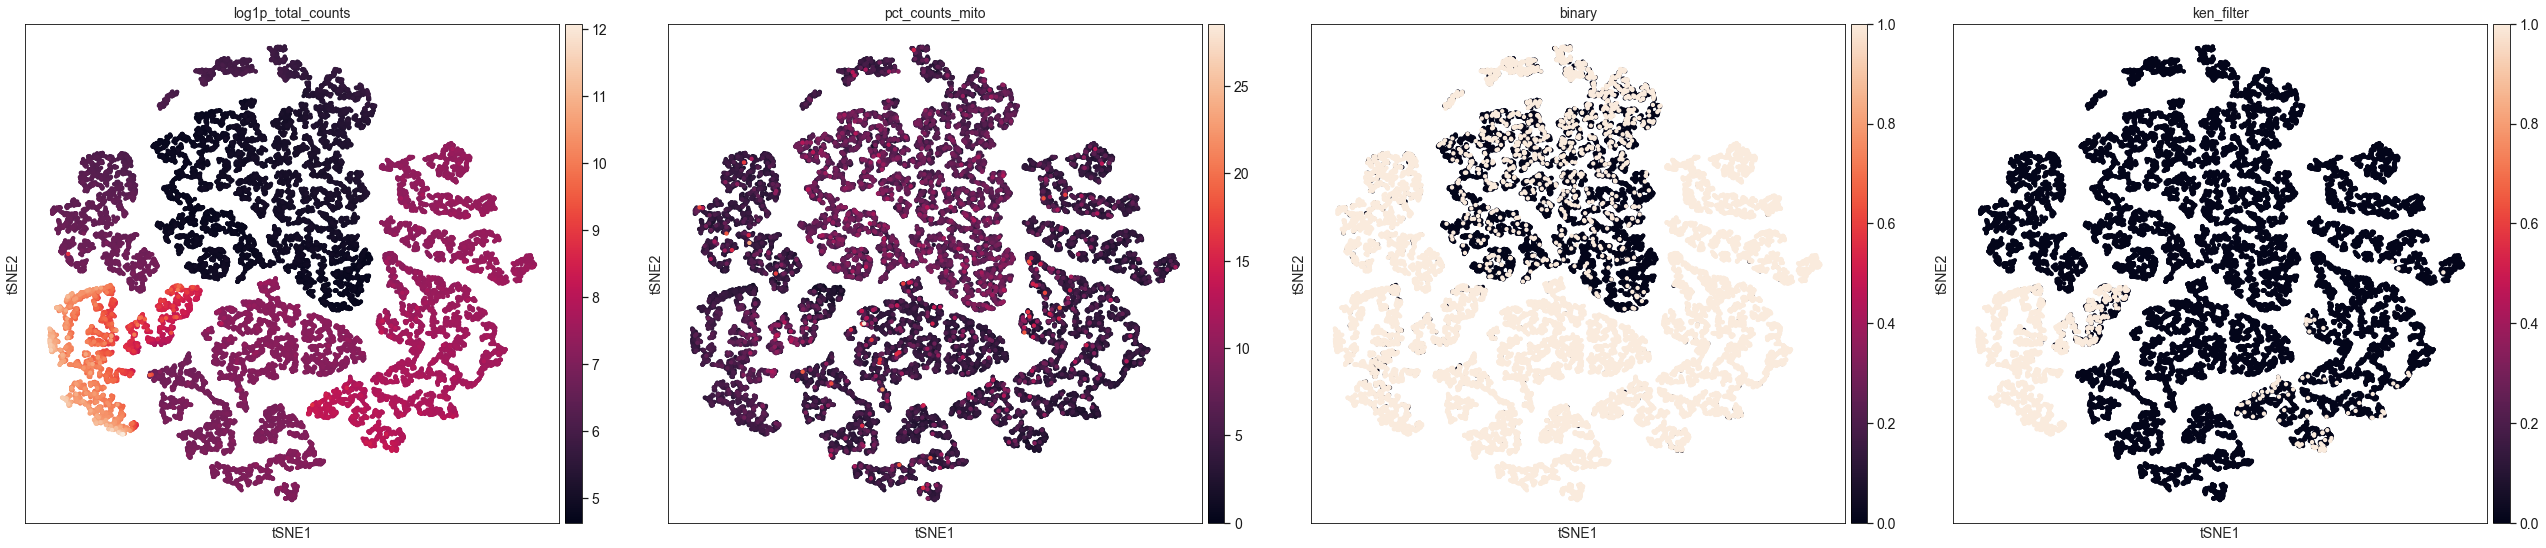

In [31]:
#sc.tl.tsne(test2_common_genes, n_pcs=2,n_jobs=-1) # perform tsne and plot results
sc.pl.tsne(test2_common_genes, color=['log1p_total_counts','pct_counts_mito','binary','ken_filter'], ncols=4, size=75)